Generally, Normalizing Flows are used to estimate an unkown probability distribution $p_X(x)$ of the real space variable $x$, by transforming the known latent space distribution $p_Z(z)$ (often $\mathcal{N}$(0,1)) according to 
\begin{aligned}
    p_{X}(x) = p_Z(z)\left|\det\left(\frac{\partial g(z)}{\partial z^T}\right)\right|^{-1},
\end{aligned}
where $g:Z\to X$ is a bijection. Therefore, the goal is to find $g$ or rather its inverse $f$ by tweaking the parameters $\theta$ of our network, such that
\begin{aligned}
    p_{X,\theta}(x) = p_Z(f_{\theta}(x))\left|\det\left(\frac{\partial f_{\theta}(x)}{\partial x^T}\right)\right|,
\end{aligned}
approximates the true distribution. Using the Kullback-Leibler divergence
\begin{aligned}
    D_{KL}(p_X||p_{X,\theta}) = \sum_{x\in X} p_X(x)\log\left(\frac{p_X(x)}{p_{X,\theta}(x)}\right),
\end{aligned}
which measures the difference between the true distribution $p_X$ and the modelled distribution $p_{X,\theta}$, we search for
\begin{aligned}
    \underset{\theta}{\mathrm{argmin}} ~ D_{KL}(p_X||p_{X,\theta}) & = \underset{\theta}{\mathrm{argmin}} -\sum_{x\in X} p_X(x)\log(p_{X,\theta}(x)) \\
    & \approx \underset{\theta}{\mathrm{argmin}} -\sum_{i=1}^{N} \frac{1}{N} \log(p_{X,\theta}(x_i)),
\end{aligned}
where $x_i$ are our training samples. 
Real-valued non-volume preserving (real NVP) transformations greatly simplify the calculation of $\log(p_{X,\theta}(x))$ by composing $f_{\theta}$ of a sequence of functions, whose Jacobians are triangular matrices. In the following we will see how each ''layer'' of $f_{\theta}$ is defined and how the triangular Jacobians come in handy.

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import sklearn

At first we define a single Affine Coupling Layer with its forward propagation
\begin{aligned}
y_{[1:d]} & = x_{[1:d]} \\
y_{[d:D-d]} & = x_{[d:D-d]}\odot \exp(s(x_{[1:d]})) + t(x_{[1:d]})
\end{aligned}
and backward propagation
\begin{aligned}
x_{[1:d]} & = y_{[1:d]} \\
x_{[d:D-d]} & = (y_{[d:D-d]}-t(y_{[1:d]}))\odot \exp(-s(y_{[1:d]}))
\end{aligned}
where $s$ and $t$ can be chosen freely (e.g. neural network layers). Additionally, we output
\begin{aligned}
\log\left(\det\left(\frac{\partial y}{\partial x^T}\right)\right) = \sum_{i} s(x_{[1:d]})_i,
\end{aligned}
which can be quickly derived, since the first $d$ dimensions of the input vector $x$ remain unchanged, leading to $\frac{\partial y}{\partial x^T}$ being triangular. Passing this result on, makes it easy to compute the full loss function later.

In [2]:
class AffineCouplingLayer(nn.Module):
    def __init__(self, d, D, hidden_dim):
        super().__init__()
        self.d = d
        self.D = D
        self.scale = nn.Sequential(nn.Linear(d,hidden_dim),nn.Tanh(),nn.Linear(hidden_dim,hidden_dim),nn.Tanh(),nn.Linear(hidden_dim,D-d))
        self.translation = nn.Sequential(nn.Linear(d,hidden_dim),nn.Tanh(),nn.Linear(hidden_dim,hidden_dim),nn.Tanh(),nn.Linear(hidden_dim,D-d))

    def forward(self,x):
        x_1 = x[:,:self.d]
        x_2 = x[:,self.d-self.D:]

        s = self.scale(x_1)
        t = self.translation(x_1)

        x_2 = x_2*torch.exp(s)+t

        log_det = torch.sum(s,dim=1)

        return torch.cat((x_1,x_2),dim=1), log_det
        
    def backward(self,y):
        y_1 = y[:,:self.d]
        y_2 = y[:,self.d-self.D:]

        y_2 = (y_2-self.translation(y_1))*torch.exp(-self.scale(y_1))

        return torch.cat((y_1,y_2),dim=1)

As already mentioned, a single coupling layer leaves one part of the input vector unchanged, which can be resolved by transforming the two parts of the vector in an alternating fashion. Further we can exploit the fact, that
\begin{aligned}
\det(AB) & = \det(A)\det(B) \\
\implies \log(\det(AB)) & = \log(\det(A)) + \log(\det(B))
\end{aligned}
This means, that we can just sum over the logarithms of the determinants of each single layer, to get the log determinant of the full transformation. 
For the inverse transformation we have to keep in mind, that we also have to reverse the order in which we alternate the two vector parts

In [3]:
class Network(nn.Module):

    def __init__(self, n_layers, hidden_dim, d, D):
        super().__init__()

        self.n_layers = n_layers
        self.d = d
        self.D = D
        self.net = nn.Sequential(*[AffineCouplingLayer(d,D,hidden_dim) for _ in range(n_layers)])

    def forward(self,x):
        full_log_det = 0
        for i in range(self.n_layers):
            if i % 2 == 1:
                #alternate the two parts of x
                x = torch.cat((x[:,self.d-self.D:],x[:,:self.d]),dim=1)
            x, log_det = self.net[i](x)
            full_log_det += log_det
        return x, full_log_det
    
    def backward(self,y):
        for i in range(self.n_layers):
            y = self.net[self.n_layers-i-1].backward(y)
            if (self.n_layers-i-1) % 2 == 1:
                #alternate in reverse order
                y = torch.cat((y[:,self.d-self.D:],y[:,:self.d]),dim=1)
        return y

In order to define our loss function, we note, that 
\begin{aligned}
-\log p_{X,\theta}(x) = -\log p_Z(f_{\theta}(x))-\log\left(\det\left(\frac{\partial f_{\theta}(x)}{\partial x^T}\right)\right)
\end{aligned}
where $p_Z$ is the distribution of our latent variable. Since we choose a normally distributed latent variable
\begin{aligned}
    \log(p_Z(f_{\theta}(x))) = f_{\theta}^2(x)
\end{aligned}
up to constant terms, that we can drop.

In [4]:
class NF(nn.Module):

    def __init__(self, n_layers, hidden_dim, d, D):
        super().__init__()

        self.net = Network(n_layers, hidden_dim, d, D)

    def loss(self,x):

        z, log_det = self.net(x)
        loss = torch.mean(torch.sum(z**2,dim=1)-log_det)

        return loss
    
    def sample(self,z):
        return self.net.backward(z)
    
    def inverse(self,x):
        z,_ = self.net(x)
        return z

As our real space distribution, we use the two moon dataset, included in scikit-learn and displayed below. In order to ease training, we normalize the data, so that we have a zero mean and a standard deviation of one.

mean: [ 1.51869628e-15 -8.08197953e-16]
standard deviation: [1. 1.]


(np.float64(-2.091681660897161),
 np.float64(2.1045598874606175),
 np.float64(-2.0120375840610545),
 np.float64(1.9840556091715293))

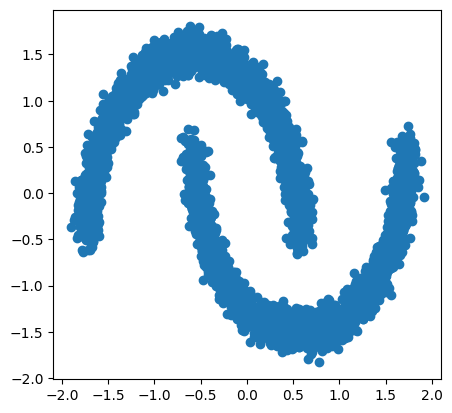

In [5]:
X,_ = sklearn.datasets.make_moons(n_samples=5000, shuffle=True, noise=0.05, random_state=None)

sigma = X.std(axis=0)
mu = X.mean(axis=0)
X = (X-mu)/sigma
print('mean: '+str(X.mean(axis=0)))
print('standard deviation: '+str(X.std(axis=0)))
plt.scatter(X[:,0],X[:,1])
plt.axis('scaled')

As mentioned above, the latent space is a 2D normal distribution, shown below.

mean: [-0.02834508  0.03619012]
standard deviation: [0.98623633 0.98422603]


(np.float64(-3.4418766362937085),
 np.float64(3.5452155837492665),
 np.float64(-3.1595269584619023),
 np.float64(3.6815241306365714))

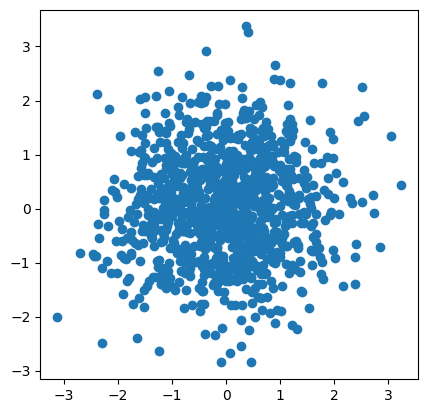

In [6]:
Z = np.random.normal(loc=0.0,scale=1.0,size=(1000,2))

print('mean: '+str(Z.mean(axis=0)))
print('standard deviation: '+str(Z.std(axis=0)))
plt.scatter(Z[:,0],Z[:,1])
plt.axis('scaled')

For training we use 4000 samples of the two moon dataset, for validation 1000 samples.

In [7]:
model = NF(9,32,1,2)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=750, eta_min=0, last_epoch=-1, verbose='deprecated')

losses = []
val_losses = []
epochs = 750

X = torch.Tensor(X)
training_data, val_data = DataLoader(X[:4000], batch_size=256, shuffle=True,drop_last=True), DataLoader(X[4000:], batch_size=256, shuffle=True,drop_last=True)

for i in range(epochs):
    batch_loss = []
    val_batch_loss = []
    
    for batch in training_data:
        optimizer.zero_grad()
        loss = model.loss(batch)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())

    for batch in val_data:
        with torch.no_grad():
            loss = model.loss(batch)
            val_batch_loss.append(loss.item())
            
    batch_loss = np.array(batch_loss)
    val_batch_loss = np.array(val_batch_loss)
    losses.append(np.mean(batch_loss))
    val_losses.append(np.mean(val_batch_loss))
    #scheduler.step()
    if i % 100 ==0:
        print(f"{i}/{epochs}")

0/750
100/750
200/750
300/750
400/750
500/750
600/750
700/750


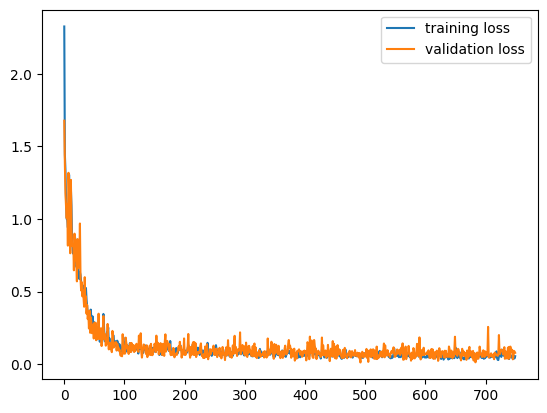

In [8]:
plt.plot(losses,label='training loss')
plt.plot(val_losses,label='validation loss')
plt.legend()

To test how well we can generate the two moon distribution, we draw samples from a 2D normal and pass them backwards through our network.

(np.float64(-2.7366555094718934),
 np.float64(2.3393855452537538),
 np.float64(-2.051907539367676),
 np.float64(2.0560245513916016))

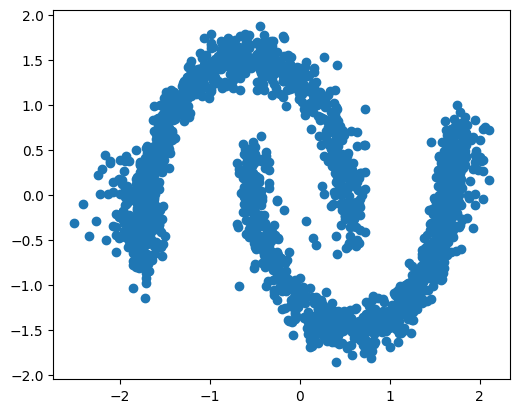

In [9]:
X_gen = model.sample(torch.normal(mean=0.0,std=1.0,size=(2000,2)))
X_gen = X_gen.detach().numpy()
plt.scatter(X_gen[:,0],X_gen[:,1])
plt.axis('scaled')

Complementary, we can test the inverse transformation, by drawing new samples from the new moon dataset and passing them forward through our network.

(np.float64(-2.2169842004776),
 np.float64(2.370337414741516),
 np.float64(-3.2642508149147034),
 np.float64(4.182803452014923))

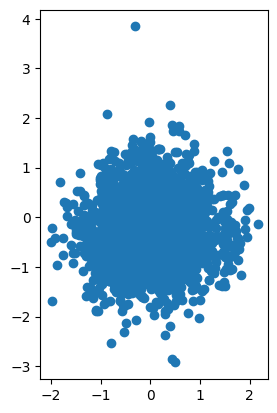

In [10]:
X_test,_ = sklearn.datasets.make_moons(n_samples=2000, shuffle=True, noise=0.05, random_state=None)
X_test = (X_test-mu)/sigma
X_test = torch.Tensor(X_test)
Z_gen = model.inverse(X_test)
Z_gen = Z_gen.detach().numpy()
plt.scatter(Z_gen[:,0],Z_gen[:,1])
plt.axis('scaled')